# Generator level analysis VBF H to WW

Using the ntuple produced with https://gitlab.cern.ch/psilva/TopLJets2015/
we select the VBF jets from $qq \rightarrow qq H \rightarrow qq WW$ and check the generator-level distribution of the particles in it.

Date: 27/06/2022

Author: P. Silva (psilva@cern.ch)

In [6]:
%load_ext autoreload
%autoreload 2

import os
import ROOT
import PyRDF
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplhep as hep
plt.style.use([hep.style.CMS, hep.style.firamath])   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
#prepare outputs
_outdir='/eos/user/p/psilva/data/vbfhww/'
os.system('mkdir -p {}/Chunks'.format(_outdir))
_plotsdir='/eos/user/p/psilva/www/vbfhwww/{}'.format(datetime.datetime.now().strftime('%Y%b%d'))
os.system('mkdir -p {}'.format(_plotsdir))
url=f'{_outdir}/MC13TeV_VBFH125toWW_ext.root'

In [90]:
def select(file_list,output_name,local=True,debug=True):
    
    """
    select the events and returns the result as a pandas DataFrame
    local: use multithread instead of spark
    debug: enable printouts
    """
    t=ROOT.TChain('analysis/data')
    for f in file_list:
        t.AddFile(f)
    
    clustered=[]
    jets=[]
    for i in range(t.GetEntries()):
        t.GetEntry(i)
        found=False
        
        #select jets
        jetkin=[]
        for j in range(t.ng):
            isjet=True
            
            gid=t.g_id[j]
            if abs(gid) in [11,13,22]: isjet=False
                
            gpt=t.g_pt[j]
            if gpt<25 : isjet=False
            
            geta=t.g_eta[j]
            #if abs(geta)>3.0 or abs(geta)<1.5: isjet=False
            
            jetkin.append([gpt,geta,isjet,[]])

        #select generator-level particles
        for j in range(t.ngpf):
            
            gidx=t.gpf_g[j]

            gpf_type=211
            if t.gpf_c[j]==0:
                if t.gpf_id[j]==22 : gpf_type=22
                elif abs(t.gpf_id[j]) in [12,14,16] : continue
                else : gpf_type=130
            if abs(t.gpf_id[j]) in [11,13,15]:
                gpf_type=11
            
            jetkin[gidx][-1].append( [gpf_type, t.gpf_pt[j], t.gpf_eta[j]] )
        
        for j in jetkin:
            
            isjet=j[2]
            if not isjet: continue
                
            n=len(j[3])
            
            hads=[c for c in j[3] if c[0]>100]
            n05=sum( [c[1]>0.5 for c in hads] )
            n1=sum( [c[1]>1 for c in hads] )
            n2=sum( [c[1]>2 for c in hads] )
            n3=sum( [c[1]>3 for c in hads] )
            n4=sum( [c[1]>4 for c in hads] )
            n5=sum( [c[1]>5 for c in hads] )
            n75=sum( [c[1]>7.5 for c in hads] )
            n10=sum( [c[1]>10 for c in hads] )
            
            jets.append( [j[0],j[1],n,n05,n1,n2,n3,n4,n5,n75,n10] )
            clustered += j[3]
        
    df=pd.DataFrame(clustered,columns=['id','pt','eta'])
    df.to_hdf(f'{_outdir}/{output_name}.h5',key='constituents')
    dfj=pd.DataFrame(jets,columns=['pt','eta','n','nh05','nh10','nh20','nh30','nh40','nh50','nh75','nh100'])
    dfj.to_hdf(f'{_outdir}/{output_name}.h5',key='jets')
    
try:
    select([url],'MC13TeV_VBFH125toWW_ext',local=True)
except Exception as e:
    print(e)

In [91]:
df=pd.read_hdf(f'{_outdir}/MC13TeV_VBFH125toWW_ext.h5',key='constituents')
dfj=pd.read_hdf(f'{_outdir}/MC13TeV_VBFH125toWW_ext.h5',key='jets')
df['abseta']=np.abs(df['eta'])
dfj['abseta']=np.abs(dfj['eta'])
etabins=np.linspace(0,5.0,15) #[1.5,1.58,1.63,1.69,1.75,1.82,1.90,1.98,2.06,2.16,2.27,2.39,2.53,2.70,2.89,3.0]
df['eta_cat'] = np.digitize(df['abseta'], 
                            bins=etabins) 
df = df.astype({'id':'int','eta_cat':'int'})
df.head()

id         pt       eta    abseta  eta_cat
0  211  17.531250  2.923394  2.923394        9
1  211   9.406250  3.015641  3.015641        9
2  211   0.937012  3.093249  3.093249        9
3  130  10.570312 -1.667251  1.667251        5
4  130  24.937500 -1.662210  1.662210        5

In [92]:
agg=df.groupby(['id','eta_cat']).agg(n=('pt','count'),eta=('abseta','mean'),pt=('pt','mean'))
agg.reset_index(inplace=True)

agg_tot=df.groupby(['eta_cat']).agg(n=('id','count'))
agg_tot.reset_index(inplace=True)
def _norm(row):
    mask=(agg_tot['eta_cat']==row['eta_cat'])
    return row['n']/agg_tot.loc[mask,'n'].values[0]
agg['wgt']=agg.apply(_norm,axis=1)

agg['PF id']=agg['id'].map({11: r'charged leptons',22:r'$\gamma$',130: r'neutral hadrons',211:r'charged hadrons'})

agg.head()

id  eta_cat    n       eta        pt       wgt            PF id
0  11        1   91  0.188373  6.853805  0.006840  charged leptons
1  11        2   98  0.562054  6.595045  0.007059  charged leptons
2  11        3  115  0.903210  7.132095  0.007628  charged leptons
3  11        4   93  1.230117  7.891166  0.005939  charged leptons
4  11        5  112  1.622051  6.630729  0.006792  charged leptons

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


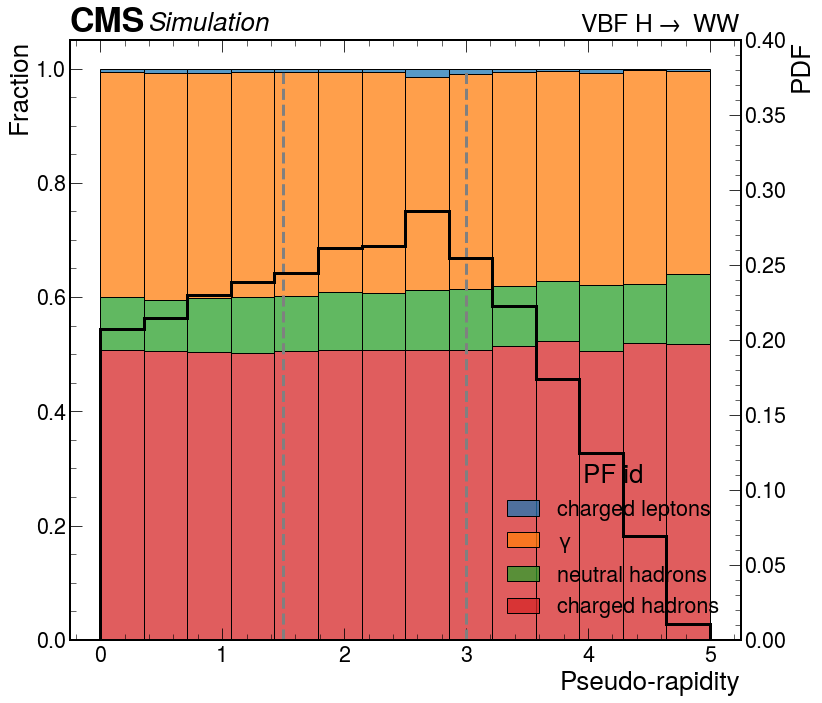

In [93]:
fig,ax=plt.subplots(figsize=(12,10))
g=sns.histplot(data=agg, ax=ax, multiple="stack",
               x="eta",weights='wgt',bins=etabins, hue="PF id")

ax.set_xlabel('Pseudo-rapidity')
ax.set_ylabel('Fraction')


axr = ax.twinx()
axr.hist(dfj['abseta'],histtype='step',bins=etabins,linewidth=3,color='k', density=True)
axr.set_ylim(0,0.4)
axr.set_ylabel('PDF')

ax.plot([1.5,1.5],[0,1],c='gray',ls='--',lw=3)
ax.plot([3.0,3.0],[0,1],c='gray',ls='--',lw=3)

fig.tight_layout()
hep.cms.label(loc=0,data=False,ax=ax,rlabel=r'VBF H$\rightarrow$ WW')
plt.show()

In [106]:
ptbins=np.linspace(0.5,20,100)
fig,ax=plt.subplots(figsize=(10,10))
mask=(np.abs(df['eta'])>1.5) & (np.abs(df['eta'])<3.0)
maskg=(df['id']==22)
ax.hist(df[mask & maskg]['pt'],bins=ptbins,label=r'$\gamma$',histtype='step',density=True,linewidth=3)
ax.hist(df[mask & ~maskg]['pt'],bins=ptbins,label='hadrons',histtype='step',density=True,linewidth=3)
ax.set_yscale('log')
ax.set_xlabel('Transverse momentum [GeV]')
ax.set_ylabel('PDF')
ax.grid()
hep.cms.label(loc=0,data=False,ax=ax,rlabel=r'VBF H$\rightarrow$ WW')
ax.text(0.35,0.9,r'$1.5<|\eta|<3.0$',transform=ax.transAxes)
ax.legend()
plt.show()

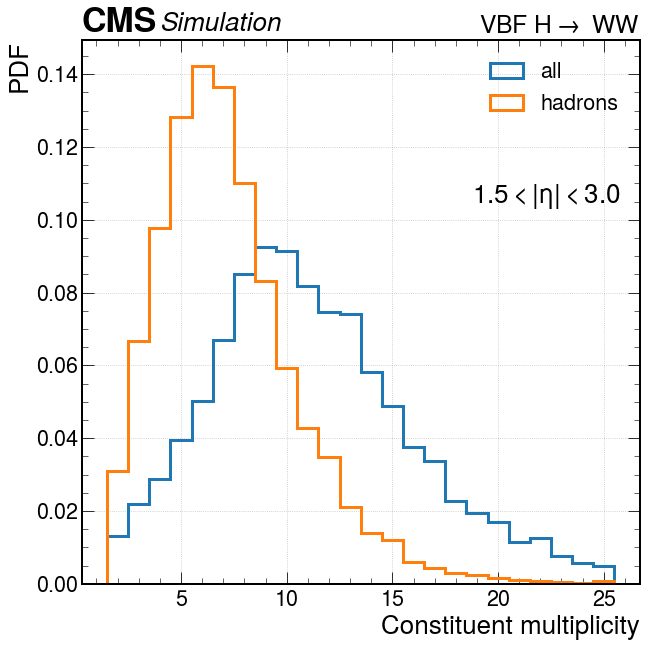

In [112]:
nbins=np.linspace(1.5,25.5,25)
fig,ax=plt.subplots(figsize=(10,10))
mask=(np.abs(dfj['eta'])>1.5) & (np.abs(dfj['eta'])<3.0)
ax.hist(dfj[mask]['n'],bins=nbins,histtype='step',density=True,linewidth=3,label='all')
ax.hist(dfj[mask]['nh05'],bins=nbins,histtype='step',density=True,linewidth=3,label='hadrons')
ax.grid()
ax.legend()
hep.cms.label(loc=0,data=False,ax=ax,rlabel=r'VBF H$\rightarrow$ WW')
ax.text(0.7,0.7,r'$1.5<|\eta|<3.0$',transform=ax.transAxes)
ax.set_xlabel('Constituent multiplicity')
ax.set_ylabel('PDF')
plt.show()

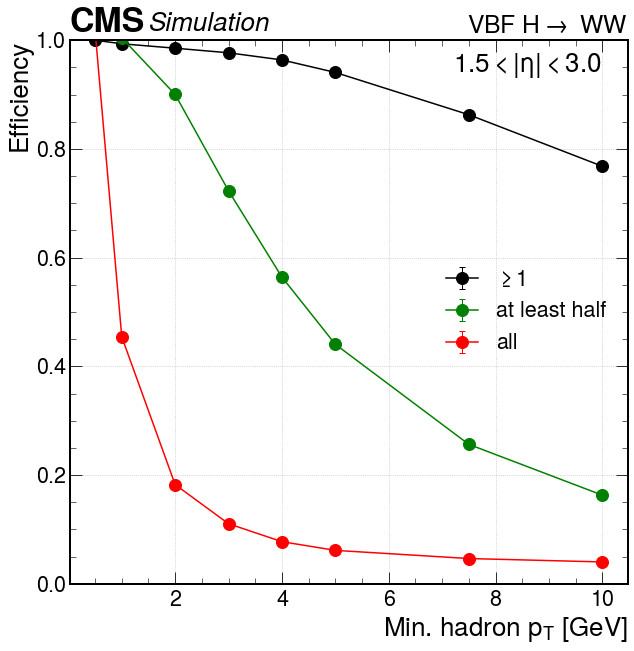

In [139]:
from statsmodels.stats.proportion import proportion_confint

def eff_unc(num,den,method='beta',alpha=0.683):

    eff = np.divide(num, den, out=np.zeros_like(num, dtype=float), where=den!=0)        
    ci=proportion_confint(num, den, alpha=alpha, method=method)
    deff=np.array([eff-ci[0],ci[1]-eff])
    
    return eff,deff


x=[]
num,numhalf,numall=[],[],[]
den=[]
for thr in ['05','10','20','30','40','50','75','100']:
    
    mask_thr=(dfj[mask][f'nh{thr}']>0)
    num.append( mask_thr.sum() )
    
    mask_thr_half=(dfj[mask][f'nh{thr}']>=0.5*dfj[mask]['nh05'])
    numhalf.append(mask_thr_half.sum() )

    mask_thr_all=(dfj[mask][f'nh{thr}']==dfj[mask]['nh05'])
    numall.append(mask_thr_all.sum() )
    
    den.append( num[0] )
    x.append(float(thr)/10.)

y,ey=eff_unc(num,den)    
yhalf,eyhalf=eff_unc(numhalf,den)    
yall,eyall=eff_unc(numall,den)    
    
ebar_style={'marker':'o','elinewidth':1,'capsize':3,'markersize':12}
plt.errorbar(x,y,yerr=ey,**ebar_style,label=r'$\geq$1',color='k')
plt.errorbar(x,yhalf,yerr=eyhalf,**ebar_style,label=r'at least half',color='green')
plt.errorbar(x,yall,yerr=eyall,**ebar_style,label=r'all',color='red')
plt.legend()
plt.grid()
plt.xlabel(r'Min. hadron $p_{T}$ [GeV]')
plt.ylabel('Efficiency')
plt.ylim(0,1)
hep.cms.label(loc=0,data=False,rlabel=r'VBF H$\rightarrow$ WW')
plt.text(0.65,0.9,r'$1.5<|\eta|<3.0$',transform=ax.transAxes)
plt.show()